In [1]:
!pip install opencv-python
!pip install pytesseract
!pip install easyocr
!pip install transformers
!pip install torch
!pip install pillow
!pip install spacy
!pip install git+https://github.com/lukas-blecher/LaTeX-OCR.git

  Cloning https://github.com/lukas-blecher/LaTeX-OCR.git to /tmp/pip-req-build-qfznc696
  Running command git clone --filter=blob:none --quiet https://github.com/lukas-blecher/LaTeX-OCR.git /tmp/pip-req-build-qfznc696
  Resolved https://github.com/lukas-blecher/LaTeX-OCR.git to commit 5c1ac929bd19a7ecf86d5fb8d94771c8969fcb80
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 17.1 MB/s eta 0:00:0031m17.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
import cv2
import pytesseract
import easyocr
import numpy as np
from transformers import pipeline
from PIL import Image
import spacy
import re
from collections import Counter
import os
import glob
from datetime import datetime
import json
from pix2tex.cli import LatexOCR
import pytesseract

/home/raulm/Documents/UNB/ist/jupyter_lab/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/raulm/Documents/UNB/ist/jupyter_lab/lib/python3.12/site-packages/pydantic/main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=... 0.058823529411764705)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [ ]:
!rm -rf semana_07ex
!unzip math.zip

Archive:  math.zip
   creating: semana_07ex/
 extracting: semana_07ex/semana_07ex-3.png  
 extracting: semana_07ex/semana_07ex-1.png  
 extracting: semana_07ex/semana_07ex-2.png  


In [ ]:
import os

folder_path = '/content/semana_07ex'
filenames = sorted(os.listdir(folder_path))  # Sort filenames
file_count = 1

for filename in filenames:
    source_path = os.path.join(folder_path, filename)
    new_filename = f"pagina_{file_count}.png"
    destination_path = os.path.join(folder_path, new_filename)
    os.rename(source_path, destination_path)
    file_count += 1

print("Files renamed successfully!")

Files renamed successfully!


In [4]:
class OCREngine:
    def __init__(self, use_mt5=True):
        """Inicializa os modelos e configurações necessárias"""
        print("[DEBUG] Iniciando OCREngine...")
        self.reader = easyocr.Reader(['pt'])
        if use_mt5:
            self.nlp_transformer = pipeline("text2text-generation", model="google/mt5-small")
        self.use_mt5 = use_mt5

        # Adiciona inicialização do pix2tex
        try:
            from pix2tex.cli import LatexOCR
            self.pix2tex = LatexOCR()
            print("[DEBUG] Pix2Tex inicializado com sucesso")
        except Exception as e:
            print(f"[ERRO] Falha ao inicializar Pix2Tex: {e}")
            self.pix2tex = None
        print("[DEBUG] OCREngine inicializado com sucesso")

    def analyze_content_type(self, image):
        """Analisa o tipo de conteúdo da imagem antes do processamento"""
        print("[DEBUG] Analisando tipo de conteúdo...")

        # Converte para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Contagem de símbolos matemáticos comuns
        math_symbols = ['∑', '∫', '√', '÷', '×', '±', '∞', '≠', '≈', '≤', '≥']
        math_symbol_count = 0

        # Usa OCR básico para detectar símbolos
        text = pytesseract.image_to_string(gray)
        for symbol in math_symbols:
            if symbol in text:
                math_symbol_count += 1

        # Analisa densidade de texto vs. símbolos
        words = len(text.split())
        math_ratio = math_symbol_count / max(words, 1)

        content_type = {
            'is_text': words > 10,
            'has_math': math_ratio > 0.1,
            'is_mixed': words > 10 and math_ratio > 0.1
        }

        print(f"[DEBUG] Análise de conteúdo: {content_type}")
        return content_type

    def convert_png_to_various_formats(self, png_path):
        """Converte a imagem para diferentes formatos para processamento"""
        print("[DEBUG] Convertendo imagem para diferentes formatos...")
        original = cv2.imread(png_path)

        if original is None:
            raise ValueError(f"Não foi possível ler a imagem no caminho: {png_path}")

        formats = {
            'original': original,
            'grayscale': cv2.cvtColor(original, cv2.COLOR_BGR2GRAY),
            'binary': cv2.threshold(
                cv2.cvtColor(original, cv2.COLOR_BGR2GRAY),
                127, 255, cv2.THRESH_BINARY
            )[1],
            'adaptive': cv2.adaptiveThreshold(
                cv2.cvtColor(original, cv2.COLOR_BGR2GRAY),
                255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
            ),
            'denoised': cv2.fastNlMeansDenoising(
                cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
            )
        }
        print("[DEBUG] Conversão de formatos concluída")
        return formats

    def preprocess_image(self, image, content_type):
        """Pré-processa a imagem baseado no tipo de conteúdo"""
        print("[DEBUG] Iniciando pré-processamento...")

        # Converte para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if content_type['is_text']:
            # Otimização para texto
            processed = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY, 11, 2
            )
        else:
            # Preserva mais detalhes para equações
            processed = cv2.threshold(
                gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
            )[1]

        print("[DEBUG] Pré-processamento concluído")
        return processed

    def extract_text(self, image, method='tesseract'):
        """Extrai texto usando o método especificado"""
        print(f"[DEBUG] Extraindo texto com {method}...")

        if method == 'tesseract':
            try:
                text = pytesseract.image_to_string(image, lang='por')
                print("[DEBUG] Extração com Tesseract concluída")
                return text.strip()
            except Exception as e:
                print(f"[ERRO] Falha no Tesseract: {e}")
                return ""

        elif method == 'easyocr':
            try:
                results = self.reader.readtext(image)
                text = " ".join([result[1] for result in results])
                print("[DEBUG] Extração com EasyOCR concluída")
                return text.strip()
            except Exception as e:
                print(f"[ERRO] Falha no EasyOCR: {e}")
                return ""

        elif method == 'pix2tex':
            try:
                if self.pix2tex is None:
                    print("[ERRO] Pix2Tex não foi inicializado corretamente")
                    return ""

                # Converte a imagem para PIL Image se necessário
                if isinstance(image, np.ndarray):
                    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                text = self.pix2tex(image)
                print("[DEBUG] Extração com Pix2Tex concluída")
                return text.strip()
            except Exception as e:
                print(f"[ERRO] Falha no Pix2Tex: {e}")
                return ""

        return ""

    def process_with_mt5(self, text):
        """Melhora o texto usando mT5"""
        print("[DEBUG] Processando texto com mT5...")
        if not self.use_mt5:
            return text
        try:
            improved = self.nlp_transformer(text[:500], max_length=500)[0]['generated_text']
            print("[DEBUG] Processamento mT5 concluído")
            return improved
        except Exception as e:
            print(f"[ERRO] Falha no processamento mT5: {e}")
            return text

    def process_with_latex_ocr(self, image):
        """Extrai equações usando LaTeX OCR"""
        print("[DEBUG] Tentando processar com LaTeX OCR...")
        try:
            if isinstance(image, np.ndarray):
                image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            # Verifica se há realmente conteúdo matemático
            if not self.has_math_content(image):
                print("[DEBUG] Sem conteúdo matemático detectado")
                return ""

            if self.latex_ocr is None:
                print("[DEBUG] Inicializando LaTeX OCR...")
                self.latex_ocr = LatexOCR()

            result = self.latex_ocr(image)
            print("[DEBUG] Processamento LaTeX OCR concluído")
            return result

        except Exception as e:
            print(f"[ERRO] Falha no LaTeX OCR: {e}")
            return ""

    def has_math_content(self, image):
        """Verifica se a imagem contém conteúdo matemático"""
        print("[DEBUG] Verificando conteúdo matemático...")

        # Converte para escala de cinza se necessário
        if isinstance(image, Image.Image):
            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
        elif len(image.shape) > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Lista de símbolos matemáticos comuns
        math_symbols = ['∑', '∫', '√', '÷', '×', '±', '∞', '≠', '≈', '≤', '≥']

        # Usa OCR para detectar símbolos
        text = pytesseract.image_to_string(image)

        # Conta símbolos matemáticos
        math_count = sum(1 for symbol in math_symbols if symbol in text)

        # Verifica padrões matemáticos
        math_patterns = [
            r'\d+[+\-*/]\d+',  # Operações básicas
            r'[a-z]\^[0-9]',   # Exponentes
            r'[a-z]_[0-9]',    # Subscritos
            r'\([^)]+\)',      # Parênteses
        ]

        pattern_count = sum(1 for pattern in math_patterns if re.search(pattern, text))

        has_math = (math_count + pattern_count) > 0
        print(f"[DEBUG] Conteúdo matemático: {has_math}")
        return has_math

    def process_image(self, image_path, force_content_type=None):
        """Processa uma imagem com logging detalhado"""
        print(f"\n[DEBUG] Iniciando processamento de {image_path}")

        try:
            # Carrega a imagem
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError("Não foi possível carregar a imagem")

            # Divide a imagem em regiões para análise
            height, width = image.shape[:2]
            regions = []

            # Divide em 4 regiões (2x2 grid)
            region_h = height // 2
            region_w = width // 2
            for i in range(2):
                for j in range(2):
                    region = image[i*region_h:(i+1)*region_h, j*region_w:(j+1)*region_w]
                    regions.append(region)

            # Analisa cada região separadamente
            region_types = []
            for idx, region in enumerate(regions):
                if force_content_type:
                    region_type = force_content_type
                else:
                    # Usa OCR básico para detectar padrões na região
                    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
                    text = pytesseract.image_to_string(gray)

                    # Verifica padrões de equações (^2, frações, símbolos matemáticos)
                    has_equations = bool(re.search(r'[\^_]|/|\$|\+|-|\*|=|∫|∑|√', text))
                    # Verifica se tem texto substancial
                    has_text = len(text.split()) > 5

                    region_type = {
                        'has_math': has_equations,
                        'is_text': has_text
                    }
                region_types.append(region_type)

            # Determina o tipo geral do conteúdo
            content_type = {
                'is_text': any(r['is_text'] for r in region_types),
                'has_math': any(r['has_math'] for r in region_types)
            }

            # Pré-processa a imagem
            processed = self.preprocess_image(image, content_type)

            results = {}

            # Processa com métodos apropriados para cada região
            for idx, (region, region_type) in enumerate(zip(regions, region_types)):
                if region_type['is_text']:
                    text_result = self.extract_text(region, 'tesseract')
                    if text_result:
                        results[f'region_{idx}_tesseract'] = text_result

                    easyocr_result = self.extract_text(region, 'easyocr')
                    if easyocr_result:
                        results[f'region_{idx}_easyocr'] = easyocr_result

                if region_type['has_math']:
                    pix2tex_result = self.extract_text(region, 'pix2tex')
                    if pix2tex_result:
                        results[f'region_{idx}_pix2tex'] = pix2tex_result

            # Processa imagem inteira também
            if content_type['is_text']:
                results['full_tesseract'] = self.extract_text(processed, 'tesseract')
                results['full_easyocr'] = self.extract_text(processed, 'easyocr')

            if self.pix2tex is not None:  # Se pix2tex está disponível
                    results['full_pix2tex'] = self.extract_text(image, 'pix2tex')

            # Combina resultados
            final_text = self.combine_results(results)

            # Pós-processamento com mT5 se disponível
            if self.use_mt5:
                final_text = self.process_with_mt5(final_text)

            print("[DEBUG] Processamento concluído com sucesso")

            # Prepara o resultado
            result = {
                'text': final_text,
                'content_type': content_type,
                'methods_used': list(set(m.split('_')[1] for m in results.keys() if '_' in m)),
                'individual_results': results
            }

            # Extrai número da página
            try:
                page_num = os.path.basename(image_path).split('_')[1].split('.')[0]
            except:
                page_num = '1'

            # Gera HTML
            html_path = self.generate_html_output(result, page_num)
            result['html_path'] = html_path

            return result

        except Exception as e:
            print(f"[ERRO] Falha no processamento: {e}")
            import traceback
            print(f"[ERRO] Detalhes: {traceback.format_exc()}")
            return None

    def generate_html_output(self, result, page_num, output_dir='resultados'):
        """Gera e salva o resultado em formato HTML"""
        print("[DEBUG] Gerando saída HTML...")

        os.makedirs(output_dir, exist_ok=True)
        html_path = os.path.join(output_dir, f'pagina_{page_num}_resultados.html')

        css_style = """
            body {
                font-family: Arial, sans-serif;
                line-height: 1.6;
                max-width: 800px;
                margin: 2rem auto;
                padding: 1rem;
            }
            .section {
                margin: 2rem 0;
                padding: 1rem;
                border: 1px solid #ddd;
                border-radius: 4px;
            }
            .method-title {
                color: #2c3e50;
                border-bottom: 2px solid #3498db;
                padding-bottom: 0.5rem;
            }
            .region {
                margin: 1rem 0;
                padding: 1rem;
                background-color: #f8f9fa;
                border-left: 3px solid #3498db;
            }
            .method {
                margin: 0.5rem 0;
                padding: 0.5rem;
                background-color: white;
            }
            .math {
                overflow-x: auto;
                padding: 1em;
                margin: 1em 0;
                background: #f8f9fa;
            }
        """

        # Prepara o conteúdo de cada região/método
        regions_content = ""
        for key, text in result['individual_results'].items():
            if text and not text.isspace():
                # Escapa o texto para HTML
                escaped_text = text.replace("<", "&lt;").replace(">", "&gt;").replace("\n", "<br>")
                regions_content += f"""
                <div class="region">
                    <h3>{key}</h3>
                    <div class="method">{escaped_text}</div>
                </div>
                """

        html_content = f"""
        <!DOCTYPE html>
        <html lang="pt-BR">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Resultado OCR - Página {page_num}</title>
            <script type="text/javascript" async
                src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
            </script>
            <script type="text/x-mathjax-config">
                MathJax.Hub.Config({{
                    tex2jax: {{
                        inlineMath: [['$','$'], ['\\\\(','\\\\)']],
                        displayMath: [['$$','$$'], ['\\\\[','\\\\]']],
                        processEscapes: true
                    }},
                    "HTML-CSS": {{
                        availableFonts: ["TeX"],
                        scale: 130
                    }}
                }});
            </script>
            <style>
                {css_style}
            </style>
        </head>
        <body>
            <h1>Resultado OCR - Página {page_num}</h1>

            <div class="section">
                <h2 class="method-title">Resultado Combinado</h2>
                <div class="content">{result['text'].replace(chr(10), '<br>')}</div>
            </div>

            <div class="section">
                <h2 class="method-title">Resultados por Região e Método</h2>
                {regions_content}
            </div>

            <div class="section">
                <h2 class="method-title">Informações da Análise</h2>
                <ul>
                    <li>Tipo de conteúdo: {result['content_type']}</li>
                    <li>Métodos utilizados: {', '.join(result['methods_used'])}</li>
                    <li>Caracteres processados: {len(result['text'])}</li>
                </ul>
            </div>
        </body>
        </html>
        """

        with open(html_path, 'w', encoding='utf-8') as f:
            f.write(html_content)

        print(f"[DEBUG] HTML gerado em: {html_path}")
        return html_path

    def combine_results(self, results):
        """Combina resultados de diferentes métodos"""
        print("[DEBUG] Combinando resultados...")

        if not results:
            return ""

        # Remove resultados vazios
        valid_results = {k: v for k, v in results.items() if v.strip()}

        if not valid_results:
            return ""

        # Combina os resultados por região e método
        combined_text = []

        # Primeiro processa os resultados full_*
        full_results = []
        if 'full_tesseract' in valid_results:
            full_results.append(valid_results['full_tesseract'])
        if 'full_easyocr' in valid_results:
            full_results.append(valid_results['full_easyocr'])
        if 'full_pix2tex' in valid_results:
            full_results.append(valid_results['full_pix2tex'])

        # Se tiver resultados full, usa o mais longo
        if full_results:
            combined_text.append(max(full_results, key=len))

        # Depois processa os resultados por região
        for i in range(4):  # Para cada região
            region_results = []

            # Coleta resultados de cada método para esta região
            region_key = f'region_{i}_tesseract'
            if region_key in valid_results:
                region_results.append(valid_results[region_key])

            region_key = f'region_{i}_easyocr'
            if region_key in valid_results:
                region_results.append(valid_results[region_key])

            region_key = f'region_{i}_pix2tex'
            if region_key in valid_results:
                # Para resultados LaTeX, adiciona delimitadores
                latex_result = valid_results[region_key]
                if latex_result and not latex_result.isspace():
                    region_results.append(f'$${latex_result}$$')

            # Se tem resultados para esta região, usa o mais longo
            if region_results:
                best_result = max(region_results, key=len)
                if best_result and not best_result.isspace():
                    combined_text.append(best_result)

        # Junta todos os resultados
        final_text = '\n\n'.join(filter(None, combined_text))

        print("[DEBUG] Resultados combinados com sucesso")
        return final_text

    def save_debug_image(self, image, name, output_dir='debug'):
        """Salva imagens de debug para análise"""
        os.makedirs(output_dir, exist_ok=True)
        path = os.path.join(output_dir, f"{name}.png")
        cv2.imwrite(path, image)
        print(f"[DEBUG] Imagem salva em {path}")

    def process_batch(self, image_dir, output_dir='resultados'):
        """Processa um lote de imagens"""
        print(f"[DEBUG] Iniciando processamento em lote de {image_dir}")

        os.makedirs(output_dir, exist_ok=True)
        results = {}

        for filename in os.listdir(image_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(image_dir, filename)
                print(f"\n[DEBUG] Processando {filename}")

                result = self.process_image(image_path)
                if result:
                    results[filename] = result

                    # Salva resultado individual
                    output_path = os.path.join(output_dir, f"{filename}_resultado.txt")
                    with open(output_path, 'w', encoding='utf-8') as f:
                        f.write(f"=== Resultado para {filename} ===\n\n")
                        f.write(f"Tipo de conteúdo: {result['content_type']}\n")
                        f.write(f"Métodos usados: {result['methods_used']}\n\n")
                        f.write(result['text'])

        # Salva relatório geral
        report_path = os.path.join(output_dir, "relatorio_geral.txt")
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("=== Relatório Geral de OCR ===\n\n")
            f.write(f"Total de imagens processadas: {len(results)}\n\n")

            for filename, result in results.items():
                f.write(f"\nArquivo: {filename}\n")
                f.write(f"Tipo de conteúdo: {result['content_type']}\n")
                f.write(f"Métodos usados: {result['methods_used']}\n")
                f.write(f"Tamanho do texto: {len(result['text'])} caracteres\n")

        print(f"[DEBUG] Processamento em lote concluído. Relatório salvo em {report_path}")
        return results

In [7]:
def main():
    """Interface interativa para processamento de imagens"""

    # Configurações básicas
    pasta_entrada = 'assets/semana_07ex/'

    # Debug: Check if input directory exists
    print(f"\nDebug: Verificando pasta de entrada: {pasta_entrada}")
    if os.path.exists(pasta_entrada):
        print(f"✓ Pasta encontrada")
        print("Arquivos encontrados:")
        for file in os.listdir(pasta_entrada):
            print(f"  - {file}")
    else:
        print(f"✗ Pasta não encontrada: {pasta_entrada}")
        return None

    # Criação do engine
    print("\nInicializando OCR Engine...")
    engine = OCREngine()

    # Lista métodos disponíveis
    metodos_disponiveis = {
        '1': ('tesseract', 'OCR usando Tesseract (básico)'),
        '2': ('easyocr', 'OCR usando EasyOCR (robusto para múltiplos idiomas)'),
        '3': ('pix2tex', 'OCR especializado em equações matemáticas')
    }

    # Mostra opções disponíveis
    print("\n=== Métodos de OCR Disponíveis ===")
    for key, (metodo, desc) in metodos_disponiveis.items():
        print(f"{key}: {desc}")

    # Opção de seleção automática
    print("A: Seleção automática baseada no conteúdo da imagem")

    # Seleciona métodos
    while True:
        try:
            escolha = input("\nEscolha os números dos métodos (separados por espaço) ou 'A' para automático: ").strip().upper()
            if escolha == 'A':
                metodos_escolhidos = None
                break
            else:
                escolhas = escolha.split()
                metodos_escolhidos = [metodos_disponiveis[e][0] for e in escolhas]
                break
        except KeyError:
            print("Erro: Escolha apenas números válidos da lista acima ou 'A'.")

    # Opção de tipo de conteúdo
    print("\n=== Tipo de Conteúdo ===")
    print("1: Detectar automaticamente")
    print("2: Forçar processamento como texto")
    print("3: Forçar processamento como equações")
    print("4: Processar como conteúdo misto")

    while True:
        content_type_choice = input("\nEscolha o tipo de conteúdo: ")
        if content_type_choice in ['1', '2', '3', '4']:
            break
        print("Opção inválida. Escolha 1, 2, 3 ou 4.")

    # Define tipo de conteúdo
    force_content_type = None
    if content_type_choice == '2':
        force_content_type = {'is_text': True, 'has_math': False}
    elif content_type_choice == '3':
        force_content_type = {'is_text': False, 'has_math': True}
    elif content_type_choice == '4':
        force_content_type = {'is_text': True, 'has_math': True}

    # Seleção de páginas
    print("\n=== Opções de Processamento ===")
    print("1: Todas as páginas")
    print("2: Página específica")
    print("3: Intervalo de páginas")

    while True:
        opcao_paginas = input("\nEscolha uma opção: ")
        try:
            if opcao_paginas == '1':
                pattern = os.path.join(pasta_entrada, '*.png')
                arquivos = sorted(glob.glob(pattern))
                print(f"Debug: Arquivos encontrados com o padrão {pattern}:")
                for arq in arquivos:
                    print(f"  - {arq}")
                pages = list(range(1, len(arquivos) + 1))
                break
            elif opcao_paginas == '2':
                num_pagina = int(input("Digite o número da página: "))
                pages = [num_pagina]
                break
            elif opcao_paginas == '3':
                inicio = int(input("Página inicial: "))
                fim = int(input("Página final: "))
                if inicio > fim:
                    print("Erro: Página inicial deve ser menor que a final")
                    continue
                pages = list(range(inicio, fim + 1))
                break
            else:
                print("Opção inválida. Escolha 1, 2 ou 3.")
        except ValueError:
            print("Por favor, digite números válidos.")

    # Processamento
    results = {}
    total_pages = len(pages)

    print(f"\nIniciando processamento de {total_pages} página(s)...")
    if metodos_escolhidos:
        print(f"Métodos selecionados: {', '.join(metodos_escolhidos)}")
    else:
        print("Usando seleção automática de métodos baseada no conteúdo")

    for idx, page_num in enumerate(pages, 1):
        print(f"\nProcessando página {page_num} ({idx}/{total_pages})...")
        image_path = os.path.join(pasta_entrada, f'pagina_{page_num}.png')

        # Debug: File path checking
        print(f"Debug: Procurando arquivo em: {image_path}")

        # Verifica se existe arquivo com outro nome
        if not os.path.exists(image_path):
            print(f"Debug: Arquivo não encontrado no caminho padrão")
            print(f"Debug: Procurando arquivos alternativos com padrão: *_{page_num}.png")

            arquivos = glob.glob(os.path.join(pasta_entrada, f'*_{page_num}.png'))
            if arquivos:
                image_path = arquivos[0]
                print(f"Debug: Arquivo alternativo encontrado: {image_path}")
            else:
                print(f"Debug: Nenhum arquivo alternativo encontrado para página {page_num}")
                continue

        try:
            result = engine.process_image(image_path, force_content_type)

            if result:
                # Salva resultados
                output_dir = 'resultados'
                os.makedirs(output_dir, exist_ok=True)

                output_path = os.path.join(output_dir, f'pagina_{page_num}_resultados.txt')
                with open(output_path, 'w', encoding='utf-8') as f:
                    f.write(f"=== Resultados da Imagem {page_num} ===\n\n")
                    f.write(result['text'])

                results[page_num] = result

                print(f"✓ Página {page_num} processada com sucesso")
                print(f"  - Tipo de conteúdo: {result['content_type']}")
                print(f"  - Métodos utilizados: {result['methods_used']}")
                print(f"  - Caracteres processados: {len(result['text'])}")
                print(f"  Resultados salvos em:")
                print(f"    - TXT: {output_path}")
                print(f"    - HTML: {result['html_path']}")

            else:
                print(f"✗ Falha no processamento da página {page_num}")

        except Exception as e:
            print(f"Erro ao processar página {page_num}: {str(e)}")
            import traceback
            print("Detalhes do erro:", traceback.format_exc())

    print("\n=== Processamento Concluído ===")
    print(f"Total de páginas processadas: {len(results)}/{total_pages}")
    print(f"Resultados salvos na pasta: {os.path.abspath('resultados')}")

    # Gera relatório final
    with open(os.path.join('resultados', 'relatorio_final.txt'), 'w', encoding='utf-8') as f:
        f.write("=== Relatório de Processamento OCR ===\n\n")
        f.write(f"Total de páginas processadas: {len(results)}/{total_pages}\n\n")

        for page_num, result in results.items():
            f.write(f"\nPágina {page_num}:\n")
            f.write(f"- Tipo de conteúdo: {result['content_type']}\n")
            f.write(f"- Métodos utilizados: {result['methods_used']}\n")
            f.write(f"- Tamanho do texto: {len(result['text'])} caracteres\n")

    print(f"\nRelatório final gerado em: {os.path.abspath('resultados/relatorio_final.txt')}")

    return results

if __name__ == "__main__":
    results = main()


Debug: Verificando pasta de entrada: assets/semana_07ex/
✓ Pasta encontrada
Arquivos encontrados:
  - pagina_5.png
  - pagina_1.png
  - pagina_2.png
  - pagina_3.png
  - pagina_4.jpg

Inicializando OCR Engine...
[DEBUG] Iniciando OCREngine...


/home/raulm/Documents/UNB/ist/jupyter_lab/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


[DEBUG] Pix2Tex inicializado com sucesso
[DEBUG] OCREngine inicializado com sucesso

=== Métodos de OCR Disponíveis ===
1: OCR usando Tesseract (básico)
2: OCR usando EasyOCR (robusto para múltiplos idiomas)
3: OCR especializado em equações matemáticas
A: Seleção automática baseada no conteúdo da imagem



Escolha os números dos métodos (separados por espaço) ou 'A' para automático:  1 2 3



=== Tipo de Conteúdo ===
1: Detectar automaticamente
2: Forçar processamento como texto
3: Forçar processamento como equações
4: Processar como conteúdo misto



Escolha o tipo de conteúdo:  2



=== Opções de Processamento ===
1: Todas as páginas
2: Página específica
3: Intervalo de páginas



Escolha uma opção:  1


Debug: Arquivos encontrados com o padrão assets/semana_07ex/*.png:
  - assets/semana_07ex/pagina_1.png
  - assets/semana_07ex/pagina_2.png
  - assets/semana_07ex/pagina_3.png
  - assets/semana_07ex/pagina_5.png

Iniciando processamento de 4 página(s)...
Métodos selecionados: tesseract, easyocr, pix2tex

Processando página 1 (1/4)...
Debug: Procurando arquivo em: assets/semana_07ex/pagina_1.png

[DEBUG] Iniciando processamento de assets/semana_07ex/pagina_1.png
[DEBUG] Iniciando pré-processamento...
[DEBUG] Pré-processamento concluído
[DEBUG] Extraindo texto com tesseract...
[DEBUG] Extração com Tesseract concluída
[DEBUG] Extraindo texto com easyocr...
[DEBUG] Extração com EasyOCR concluída
[DEBUG] Extraindo texto com tesseract...
[DEBUG] Extração com Tesseract concluída
[DEBUG] Extraindo texto com easyocr...
[DEBUG] Extração com EasyOCR concluída
[DEBUG] Extraindo texto com tesseract...
[DEBUG] Extração com Tesseract concluída
[DEBUG] Extraindo texto com easyocr...
[DEBUG] Extração co

In [ ]:
def test_pix2tex(file_path):
    """
    Test pix2tex on a single image and print the result

    Args:
        file_path (str): Path to the image file
    """
    print(f"\nTesting pix2tex on: {file_path}")

    try:
        # Initialize pix2tex
        print("Initializing LatexOCR...")
        model = LatexOCR()

        # Load and prepare image
        print("Loading image...")
        image = cv2.imread(file_path)
        if image is None:
            raise ValueError("Could not read image")

        # Convert to PIL Image (pix2tex expects PIL Image)
        image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Process with pix2tex
        print("Processing with pix2tex...")
        result = model(image_pil)

        # Print result
        print("\nLatex Result:")
        print("-" * 50)
        print(result)
        print("-" * 50)

        # Return for further use if needed
        return result

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

# Usage example:
if __name__ == "__main__":
    file_path = "/content/semana_07ex/pagina_5.png"  # Replace with your image path
    test_pix2tex(file_path)




Testing pix2tex on: /content/semana_07ex/pagina_5.png
Initializing LatexOCR...
Loading image...
Processing with pix2tex...

Latex Result:
--------------------------------------------------
\left\{\begin{array}{l l}{\Omega{\chi}^{2}+\mathrm{D}{\chi}+C-O}\\ {\qquad(\chi{\sqrt[[object Object]]{^{2}-4\alpha C}}}\\ {\times{\mathrm{=}}{\xrightarrow{2\alpha}}}\end{array}\right\}
--------------------------------------------------


In [ ]:
!pip install anthropic google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 15.6 MB/s eta 0:00:00



Processando imagem: /content/semana_07ex/pagina_1.png

Escolha a API:
1: Claude
2: Gemini
Digite sua escolha (1-2): 2

Processando com gemini...

Resultados salvos em HTML: api_results/result_pagina_1.html


<ipython-input-61-7076924965ac>:209: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


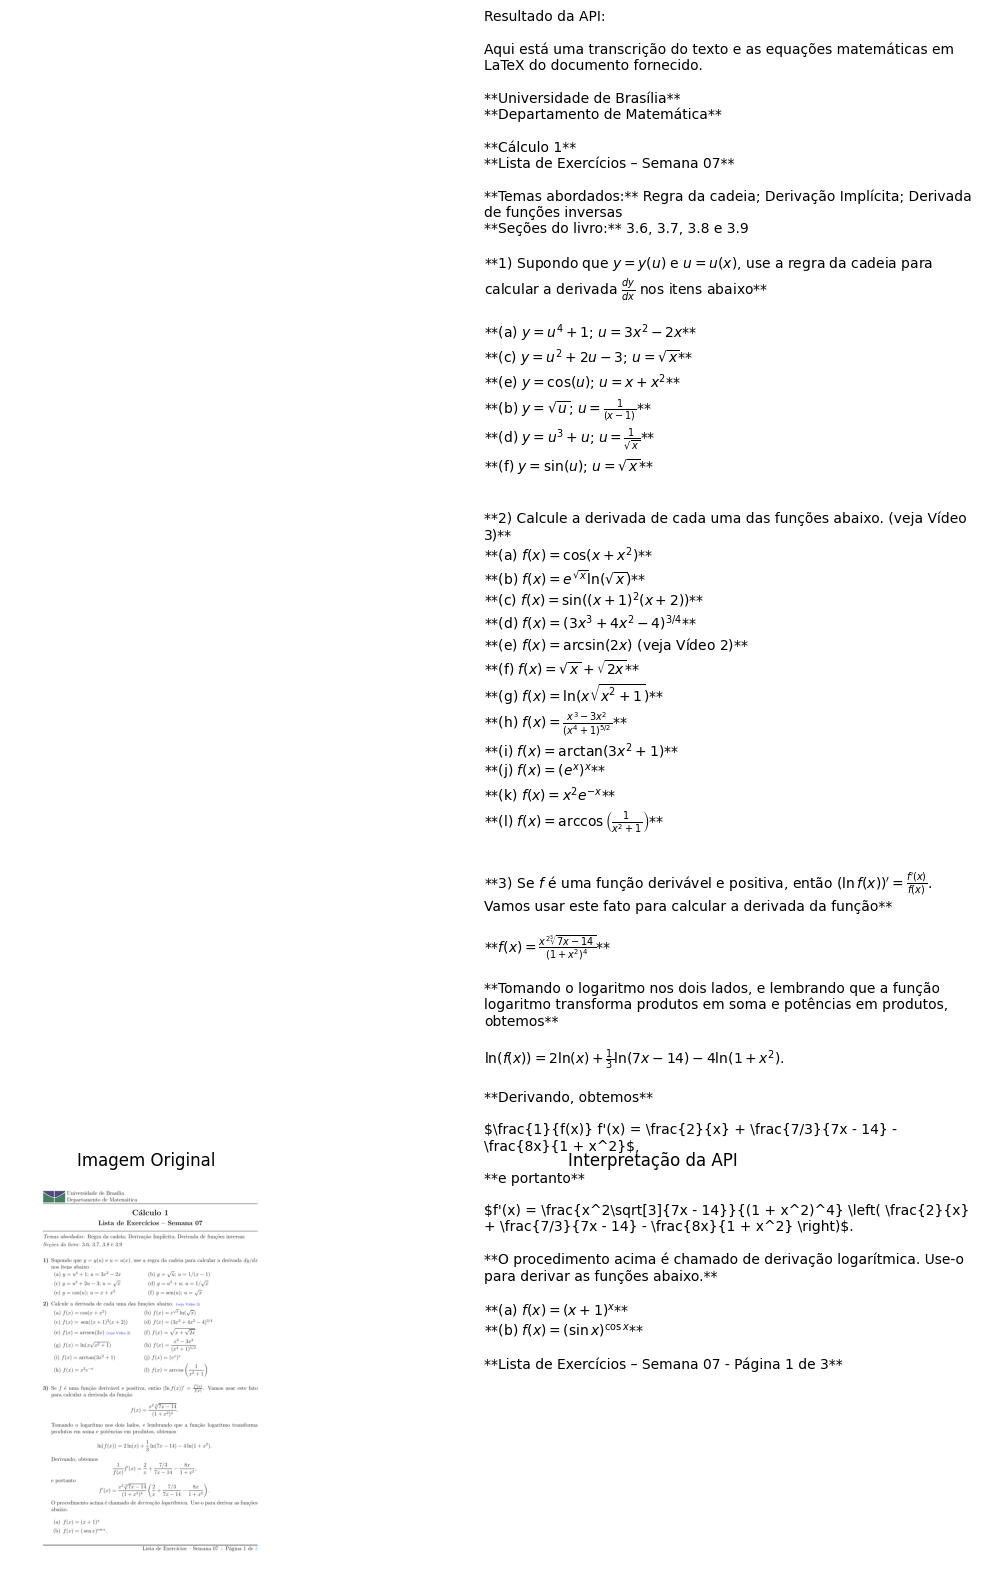


JSON salvo em: api_results/result_pagina_1_gemini.json


In [ ]:
from PIL import Image
import cv2
import numpy as np
import anthropic
import google.generativeai as genai
import json
from pathlib import Path
import matplotlib.pyplot as plt
import base64

def process_with_claude(image_path, client):
    """Process image with Claude API"""
    try:
        with open(image_path, "rb") as f:
            image_bytes = f.read()

        message = "Por favor, leia esta imagem. Se houver equações matemáticas, forneça o LaTeX correspondente. Se houver texto, transcreva-o."

        response = client.messages.create(
            model="claude-3-opus-20240229",
            max_tokens=1000,
            temperature=0,
            messages=[{
                "role": "user",
                "content": [
                    {"type": "text", "text": message},
                    {"type": "image", "source": {"type": "base64", "media_type": "image/jpeg", "data": image_bytes}}
                ]
            }]
        )
        return response.content

    except Exception as e:
        print(f"Erro com API do Claude: {str(e)}")
        return None

def process_with_gemini(image_path, model):
    """Process image with Gemini API"""
    try:
        img = Image.open(image_path)

        message = "Por favor, leia esta imagem. Se houver equações matemáticas, forneça o LaTeX correspondente. Se houver texto, transcreva-o."

        response = model.generate_content([message, img])
        return response.text

    except Exception as e:
        print(f"Erro com API do Gemini: {str(e)}")
        return None

def save_html_result(image_path, api_result, output_dir):
    """Save results in HTML with LaTeX support"""
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    html_file = output_dir / f"result_{Path(image_path).stem}.html"

    with open(image_path, "rb") as img_file:
        img_base64 = base64.b64encode(img_file.read()).decode()

    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <title>Resultado da Análise</title>

        <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
        <script id="MathJax-script" async
                src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js">
        </script>

        <style>
            body {{
                font-family: Arial, sans-serif;
                max-width: 1200px;
                margin: 0 auto;
                padding: 20px;
            }}
            .container {{
                display: flex;
                gap: 20px;
                margin-bottom: 30px;
            }}
            .image-container {{
                flex: 1;
                border: 1px solid #ddd;
                padding: 10px;
                border-radius: 5px;
            }}
            .result-container {{
                flex: 1;
                border: 1px solid #ddd;
                padding: 10px;
                border-radius: 5px;
            }}
            img {{
                max-width: 100%;
                height: auto;
            }}
            h1, h2 {{
                color: #333;
            }}
            .latex-section {{
                margin-top: 20px;
                padding: 15px;
                background-color: #f8f9fa;
                border-radius: 5px;
            }}
        </style>
    </head>
    <body>
        <h1>Resultado da Análise de Imagem</h1>

        <div class="container">
            <div class="image-container">
                <h2>Imagem Original</h2>
                <img src="data:image/jpeg;base64,{img_base64}" alt="Imagem Original">
            </div>

            <div class="result-container">
                <h2>Interpretação da API</h2>
                <div>{api_result}</div>
            </div>
        </div>

        <div class="latex-section">
            <h2>Visualização LaTeX</h2>
            <div>{api_result}</div>
        </div>
    </body>
    </html>
    """

    with open(html_file, 'w', encoding='utf-8') as f:
        f.write(html_content)

    return html_file

def test_vision_api(file_path, api_choice=None):
    """
    Test different computer vision APIs

    Args:
        file_path (str): Path to the image file
        api_choice (str, optional): 'claude' or 'gemini'. If None, will prompt user

    Returns:
        dict: Results including API response and file paths
    """
    print(f"\nProcessando imagem: {file_path}")

    try:
        # Check if file exists
        if not Path(file_path).exists():
            raise ValueError("Arquivo não encontrado")

        # Get API choice if not provided
        if api_choice is None:
            print("\nEscolha a API:")
            print("1: Claude")
            print("2: Gemini")
            while True:
                choice = input("Digite sua escolha (1-2): ")
                if choice in ['1', '2']:
                    api_choice = {
                        '1': 'claude',
                        '2': 'gemini'
                    }[choice]
                    break
                print("Escolha inválida. Digite 1 ou 2.")

        # Process with chosen API
        print(f"\nProcessando com {api_choice}...")

        if api_choice == 'claude':
            client = anthropic.Client(api_key='your_claude_api_key')
            result = process_with_claude(file_path, client)

        elif api_choice == 'gemini':
            genai.configure(api_key='INSIRA A SUA CHAVE AQUI :) ')
            model = genai.GenerativeModel('gemini-1.5-flash')
            result = process_with_gemini(file_path, model)

        if result is None:
            raise ValueError("API não retornou resultado")

        # Save HTML result
        html_path = save_html_result(file_path, result, 'api_results')
        print(f"\nResultados salvos em HTML: {html_path}")

        # Display results (optional)
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 5))

        plt.subplot(121)
        plt.imshow(img)
        plt.title('Imagem Original')
        plt.axis('off')

        plt.subplot(122)
        plt.text(0.1, 0.5, f"Resultado da API:\n\n{result}",
                 wrap=True, fontsize=10)
        plt.title('Interpretação da API')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Save JSON results
        results = {
            'image_path': str(file_path),
            'api_used': api_choice,
            'api_result': str(result),
            'html_path': str(html_path)
        }

        output_file = Path('api_results') / f"result_{Path(file_path).stem}_{api_choice}.json"
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2)

        print(f"\nJSON salvo em: {output_file}")

        return results

    except Exception as e:
        print(f"Erro processando imagem: {str(e)}")
        import traceback
        print(f"Detalhes do erro:\n{traceback.format_exc()}")
        return None


# Usage example:
if __name__ == "__main__":
    file_path = "/content/semana_07ex/pagina_1.png"  # Replace with your image path
    test_vision_api(file_path)